In [1]:
from espuma import Case_Directory, Boundary_Probe
from espuma_utils import get_stacked_biomass
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import pyvista as pv

import numpy as np

In [2]:
try:
    NOTEBOOK_NAME = __file__
except NameError:
    NOTEBOOK_NAME = __vsc_ipynb_file__ #noqa: F821 #type: ignore

colors = {
    'active': "#ff3146", 
    'inactive':"#4f4b7e",
    'labile': "#5470b8",
    'recalcitrant': "#4f4b7e"}

stack_colors = [c for k,c in colors.items() if k != 'inactive']

In [3]:
pv.start_xvfb()
pv.global_theme.trame.server_proxy_enabled = True
pv.set_jupyter_backend("static")

plt.style.use('./matplotlib_style/edwin.mplstyle')

In [4]:
of_case_constant_wet = Case_Directory("CASES_evaluate_wet_dry_ratios/flood_115200__dry_0000/")
of_case_drying_cycle = Case_Directory("CASES_evaluate_wet_dry_ratios/flood_0450__dry_1800/") 

In [5]:
sb_constant_wet = get_stacked_biomass(of_case_constant_wet)
sb_drying_cycle = get_stacked_biomass(of_case_drying_cycle)

In [6]:
prb_constant_wet = Boundary_Probe(of_case_constant_wet, of_case_constant_wet.system.boundaryProbes)
prb_drying_cycle = Boundary_Probe(of_case_drying_cycle, of_case_drying_cycle.system.boundaryProbes)

xarr_constant_wet = prb_constant_wet.array_data
xarr_drying_cycle = prb_drying_cycle.array_data

espuma_BoundaryProbes already exists :)
espuma_BoundaryProbes already exists :)


In [7]:
time_constant_wet = [t/86400 for t in of_case_constant_wet.list_times]
time_drying_cycle = [t/86400 for t in of_case_drying_cycle.list_times]


In [8]:
for of_case in (of_case_constant_wet, of_case_drying_cycle):
    cross_area_column = float(of_case.system.blockMeshDict["diameter"]) ** 2
    print(f"{of_case.path.name} -> {cross_area_column = :.3f} m²")

flood_115200__dry_0000 -> cross_area_column = 0.040 m²
flood_0450__dry_1800 -> cross_area_column = 0.040 m²


max(xar)=2.08e-02 at time:  4.00
max(xar)=9.66e-03 at time:  11.25


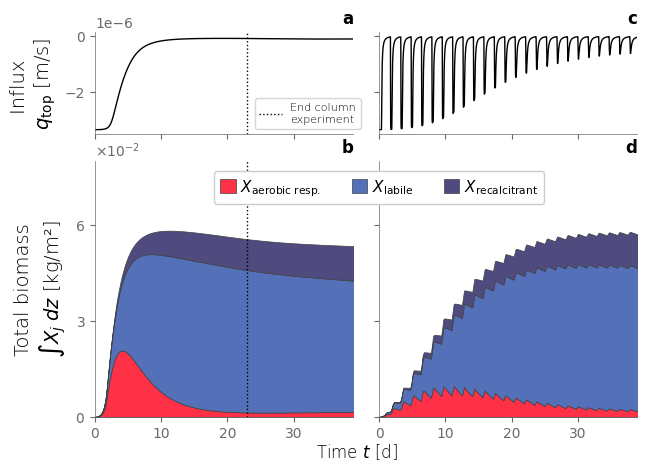

In [13]:
fig, axs = plt.subplots(2, 2, figsize=(7,5), sharex=True, sharey='row', 
    height_ratios=[1,2.5], gridspec_kw=dict(hspace=0.15, wspace=0.1))

for sb, time, ax in zip(
    (sb_constant_wet, sb_drying_cycle), 
    (time_constant_wet, time_drying_cycle),
    axs[1,:]):

    # Extract integrated variables
    xar =  [v["XAR"][0]/cross_area_column for v in sb.values()]
    xeps = [v["EPS"][0]/cross_area_column for v in sb.values()]
    xin =  [v["XI"][0]/cross_area_column  for v in sb.values()]

    polycol = ax.stackplot(
        time, 
        *(xar, xeps, xin),
        labels=(R"$X_{\mathsf{aerobic\;resp.}}$", R"$X_{\mathsf{labile}}$", R"$X_{\mathsf{recalcitrant}}$"),
        colors = stack_colors, ec='0.25', lw=0.5
    )

    print(f"{max(xar)=:.2e}", "at time: ", f"{time[np.argmax(xar)]:.2f}")

    ax.set_xlim(left=0)
    ax.ticklabel_format(axis='y', useMathText=True, scilimits=(0,0))

    ax.set_ylim(bottom=0, top=8e-2)
    ax.set_xlim(0, 39)

for xarr, time, ax in zip(
    (xarr_constant_wet, xarr_drying_cycle), 
    (time_constant_wet, time_drying_cycle),
    axs[0,:]):

    ax.plot(xarr.time/86400, xarr.isel(probes=0).Uz, lw=1)

for t, ax in zip([*'acbd'], axs.flatten()):
    ax.set_title(t, loc='right', y=1.0, weight=700)

axs[0,0].set_ylabel("Influx \n" R"$q_{\mathsf{top}}$ [m/s]")

legend = axs[1,1].legend(loc="upper center", ncols=3, bbox_to_anchor=(0, 0.99), framealpha=1, handlelength=1, handletextpad=0.3, handleheight=1)
legend.set_clip_on(False)
axs[1,0].set_ylabel("Total biomass\n" + R"$\int{X_j} \; dz$ [kg/m²]")
axs[1,0].yaxis.set_major_locator(MaxNLocator(3))

END_DAY_COLUMN_EXPERIMENT = 23
axs[1,0].axvline(x=END_DAY_COLUMN_EXPERIMENT, c='k', ls="dotted", lw=1)
axs[0,0].axvline(x=END_DAY_COLUMN_EXPERIMENT, label="End column\nexperiment", c='k', ls="dotted", lw=1)
axs[0,0].legend(
    loc='lower right', bbox_to_anchor = (1.05, 0),
    prop=dict(size=8, weight=100))

fig.supxlabel("Time $t$ [d]", weight=200, size=12, y=0.02)
# plt.savefig(
#     f"plots/{NOTEBOOK_NAME.rpartition('/')[-1].removesuffix('.ipynb')}.pdf", 
#     format="pdf", bbox_inches='tight', pad_inches=0.05
# )
plt.show()
    

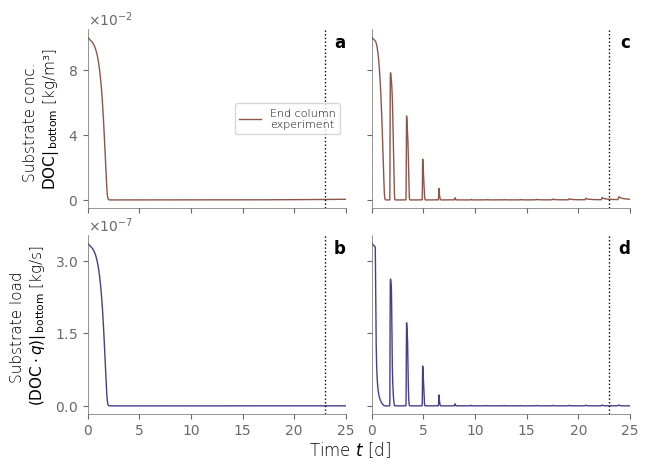

In [10]:
fig, axs = plt.subplots(2, 2, figsize=(7,5), sharex=True, sharey='row', 
    height_ratios=[1,1], gridspec_kw=dict(hspace=0.15, wspace=0.1))

for xarr, time, axr in zip(
    (xarr_constant_wet, xarr_drying_cycle), 
    (time_constant_wet, time_drying_cycle),
    axs.T):

    doc = xarr.isel(probes=0).DOC
    qin = np.abs(xarr.isel(probes=0).Uz)

    axr[0].plot(xarr.time/86400, doc, lw=1, c='tab:brown')
    axr[1].plot(xarr.time/86400, doc * qin, lw=1, c='darkslateblue')

END_DAY_COLUMN_EXPERIMENT = 23
for t, ax in zip([*'acbd'], axs.flatten()):
    ax.set_title(t, loc='right', y=0.85, weight=700)
    ax.ticklabel_format(axis='y', useMathText=True, scilimits=(0,0))
    ax.axvline(x=END_DAY_COLUMN_EXPERIMENT, c='k', ls="dotted", lw=1)
    ax.set_xlim(0, 25)

axs[0,0].set_ylabel("Substrate conc. \n" R"$\mathsf{DOC}|_{\mathsf{\,bottom}}$ [kg/m³]", fontsize=11)
axs[1,0].set_ylabel("Substrate load \n" R"$(\mathsf{DOC}\cdot q)|_{\mathsf{\,bottom}}$ [kg/s]", fontsize=11)

axs[0,0].yaxis.set_major_locator(MaxNLocator(3))
axs[1,0].yaxis.set_major_locator(MaxNLocator(3))

axs[0,0].legend(["End column\nexperiment"], loc='center right', prop=dict(size=8, weight=100))

fig.supxlabel("Time $t$ [d]", weight=200, size=12, y=0.02)
plt.show()
    